In [1]:
import torch
import torchvision
from femb.data.util import http_get, extract_archive
from femb.backbones import build_backbone
from femb.headers import LinearHeader, SphereFaceHeader, CosFaceHeader, ArcFaceHeader, MagFaceHeader
from femb.evaluation import VerificationEvaluator
from femb.data import LFWDataset, CelebADataset
from femb import FaceEmbeddingModel
from femb.preprocessing.face_detection import preprocess_image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/ysyuk/anaconda3/envs/broj-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


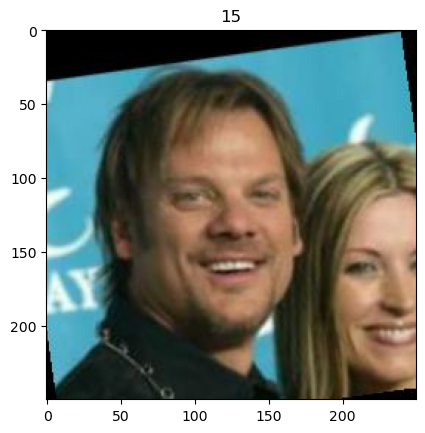

In [2]:
train_dataset = LFWDataset(split='train', aligned=True)
visualized_img = train_dataset[22]
plt.imshow(visualized_img[0])
plt.title(visualized_img[1])
plt.show()

In [3]:
preprocess = preprocess_image
preprocess_dataset = LFWDataset(split='train', aligned=True, preprocess=preprocess)

print(preprocess_dataset[6][0])

tensor([[[0.6627, 0.6627, 0.6627,  ..., 0.6118, 0.5882, 0.5843],
         [0.6627, 0.6627, 0.6667,  ..., 0.6157, 0.5882, 0.5843],
         [0.6667, 0.6667, 0.6706,  ..., 0.6157, 0.5922, 0.5843],
         ...,
         [0.0824, 0.0824, 0.0784,  ..., 0.7843, 0.7686, 0.7647],
         [0.0510, 0.0510, 0.0549,  ..., 0.7725, 0.7569, 0.7529],
         [0.0353, 0.0353, 0.0431,  ..., 0.7647, 0.7490, 0.7451]],

        [[0.6745, 0.6745, 0.6745,  ..., 0.6118, 0.5882, 0.5843],
         [0.6745, 0.6745, 0.6784,  ..., 0.6118, 0.5882, 0.5843],
         [0.6784, 0.6784, 0.6824,  ..., 0.6157, 0.5882, 0.5843],
         ...,
         [0.0824, 0.0824, 0.0784,  ..., 0.6706, 0.6549, 0.6510],
         [0.0510, 0.0510, 0.0549,  ..., 0.6549, 0.6353, 0.6314],
         [0.0353, 0.0353, 0.0431,  ..., 0.6471, 0.6275, 0.6235]],

        [[0.6000, 0.6000, 0.6000,  ..., 0.5216, 0.4902, 0.4824],
         [0.6000, 0.6000, 0.6039,  ..., 0.5216, 0.4902, 0.4824],
         [0.6039, 0.6039, 0.6039,  ..., 0.5216, 0.4902, 0.

In [4]:
batch_size = 32 
device = 'cuda'

In [5]:
# preprocessing transform (assuming alignment and so on)
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.ToPILImage()
#     # torchvision.transforms.Resize((224, 224)),
#     # # torchvision.transforms.Resize((112, 112)),
#     # torchvision.transforms.ToTensor(),
#     # # torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
#     # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     # torchvision.transforms.RandomHorizontalFlip()
#     ])

preprocess = preprocess_image
train_dataset = LFWDataset(split='train', aligned=True, preprocess=preprocess)

print(train_dataset[2][0])
# plt.imshow(train_dataset[2][0])
# plt.show()
batch_size = 32 
device = 'cuda'
# train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
# for step, batch in pbar:

#     # # skip batch if singleton
#     # if len(batch[0]) <= 1:
#     #     continue

#     inputs = batch[0]
#     labels = batch[1]
#     print(type(inputs))
#     plt.imshow(inputs[0])
#     plt.title(labels[0])
#     plt.show()
#     # 배치의 이미지 텐서를 (B, C, H, W) 형식으로 변환
#     inputs = inputs.permute(0, 3, 1, 2)  # (B, H, W, C) -> (B, C, H, W)
#     # 첫 번째 이미지 텐서를 PIL 이미지로 변환
#     pil_image = torchvision.transforms.ToPILImage()(inputs[0].cpu())

#     tensor_img,_ = face_detection.preprocess_image(np.array(pil_image))

#     # plt.imshow(inputs[0])
#     # plt.title(labels[0])
#     # plt.show()

#     print(step)
#     if step == 1:
#         break

tensor([[[0.1216, 0.1176, 0.1098,  ..., 0.1020, 0.1216, 0.1294],
         [0.1216, 0.1176, 0.1137,  ..., 0.1020, 0.1176, 0.1216],
         [0.1216, 0.1216, 0.1137,  ..., 0.1020, 0.1098, 0.1137],
         ...,
         [0.0118, 0.0118, 0.0118,  ..., 0.0902, 0.1098, 0.1137],
         [0.0118, 0.0118, 0.0157,  ..., 0.1098, 0.1255, 0.1294],
         [0.0118, 0.0118, 0.0157,  ..., 0.1176, 0.1333, 0.1373]],

        [[0.0824, 0.0784, 0.0706,  ..., 0.0627, 0.0824, 0.0902],
         [0.0824, 0.0824, 0.0745,  ..., 0.0588, 0.0784, 0.0824],
         [0.0902, 0.0863, 0.0784,  ..., 0.0588, 0.0667, 0.0706],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.0941, 0.1137, 0.1176],
         [0.0039, 0.0039, 0.0039,  ..., 0.1137, 0.1294, 0.1333],
         [0.0039, 0.0039, 0.0039,  ..., 0.1216, 0.1373, 0.1412]],

        [[0.0745, 0.0706, 0.0667,  ..., 0.0314, 0.0510, 0.0549],
         [0.0745, 0.0745, 0.0706,  ..., 0.0353, 0.0471, 0.0510],
         [0.0784, 0.0784, 0.0745,  ..., 0.0353, 0.0431, 0.